In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt

class MLP:
    """Class defining a neural network using back propagation"""
    
    def __init__(self, layers, W = None, B = None):
        """layers is initialized as a list(input_layer, ...hidden_layers..., output_layers)"""
        self.n_layers = len(layers) - 1
        self.layers = layers
        if W is None and B is None:
            self.initialize_weights()
        else:
            self.weights = W
            self.biases = B
            
        self.actual_output = 0
        
    def initialize_weights(self):
        """generate weights and biases for hidden layers 
        in a standard gaussian distribution  mean 0 deviation 1"""
        self.biases = [np.random.randn(1, y) for y in self.layers[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(self.layers[:-1], self.layers[1:])]
    
    def sigmoid(self, x):
        """The sigmoid function"""
        return 1 / (1 + np.exp(-x))    
    
    def derivative(self, sig_x):
        """return the derivative of sig_x"""
        return sig_x*(1 - sig_x)
    
    def net_error(self, tar, out):
        """compute mean square error for network"""
        err = np.mean(np.square(tar - out))
        # or (1/2)*np.sum(np.power(tar - out, 2))???
        
        return err
    
    def graph_error(self, train_array, test_array = None):
        """display graphical error"""
        plt.figure(0)
        plt.xlabel("Epochs")
        plt.ylabel("Error")
        plt.title("Back-Propagation algortihm")
        plt.plot(train_array, label="training error")
        if test_array is not None: 
            xs = np.arange(len(test_array))
            t_array = np.array(test_array).astype(np.double)
            ta_mask = np.isfinite(t_array)
            plt.plot(xs[ta_mask], t_array[ta_mask], label="testing error")
        plt.legend()
        plt.show()

    
    def feed_forward(self, input):
        """the feed forward function"""
        self.layers_output = []
        
        for index in range(self.n_layers):
            if index == 0:
                z = np.dot(input, self.weights[index].T) + self.biases[index]
                self.layers_output.append(self.sigmoid(z))
            else: 
                z = np.dot(self.layers_output[index -1], self.weights[index].T) + self.biases[index]
                self.layers_output.append(self.sigmoid(z))
        
        return self.layers_output[-1][0]
    
    def back_propagation(self, input, target, trainingRate = 0.2):
        """the back_propagation function"""
        l_errors = []
        #feed forward
        actual_error = self.net_error(target, self.feed_forward(input)) 
        
        # compute l_errors 
        for index in reversed(range(self.n_layers)):
            sig_prim = self.derivative(self.layers_output[index])
            if index == self.n_layers - 1:
                
                output_delta = -(target - self.layers_output[index])
                l_errors.append(output_delta*sig_prim)
            else:
                hidden_delta = np.dot(l_errors[-1], self.weights[index+1])*sig_prim
                l_errors.append(hidden_delta)
        
        l_errors = l_errors[::-1]
        self.layers_output.insert(0, input)
        
        # new biases and weights
        for index in range(self.n_layers ):    
            multiply = np.multiply(l_errors[index].T, self.layers_output[index])            
            self.weights[index] = self.weights[index] - trainingRate*multiply
            self.biases[index] = self.biases[index] - trainingRate*l_errors[index]
        
        #return the error calculated with the precedent weights
        return actual_error
    
    def train(self, epochs, trainingRate, training_set, testing_set, interval = 100):
        training_err = []
        testing_err = []
        
        t_input = training_set['input']
        t_output = training_set['output']
        
        test_input = testing_set['input']
        test_output = testing_set['output']
        
        for epoch in range(epochs):
            #print('Epoch {}/{}'.format(epoch +1, epochs))
            count = 0
            err = 0
            
            for x in t_input:
                # back propagation and net error
                err += self.back_propagation(x, t_output[count], trainingRate)
                count += 1               
            #print('loss = {}'.format(err/t_input.shape[0]))
            training_err.append(err/t_input.shape[0])
            
            if not epoch%interval:
                predict = []
                test_err = 0
                test_count = 0
                for x_test in test_input:
                    a = self.predict(x_test)
                    test_err += self.net_error(test_output[test_count], a) 
                    test_count += 1
                
                testing_err.append(test_err/test_input.shape[0])
            else:
                testing_err.append(None)
                
        return training_err, testing_err
    
    def predict(self, input):
        """Return predicted values of an input"""
        prediction = 0
        
        for index in range(self.n_layers):
            if index == 0:
                z = np.dot(input, self.weights[index].T) + self.biases[index]
                prediction = self.sigmoid(z)
            else: 
                z = np.dot(prediction, self.weights[index].T) + self.biases[index]
                prediction = self.sigmoid(z)
        
        return prediction
        
    def main(self, epochs, trainingRate, input, target):
        err_vector = []
        
        for epoch in range(epochs):
            count = 0
            err = 0
            
            for x in input:
                
                #back propagation
                my_err = self.back_propagation(x, target[count], trainingRate)
                
                #net error
                
                err+= self.net_error(target[count], self.layers_output[-1][0])

                count +=1
            err_vector.append(err / input.shape[0])
            
        #graph error
        self.graph_error(err_vector)

In [56]:
"""XOR learning"""

my_mlp = MLP([2, 2, 1])
my_mlp.main(1000, 0.5, np.array([[0,0],[0,1],[1,0],[1,1]]), np.array([[1],[1],[0],[0]]))

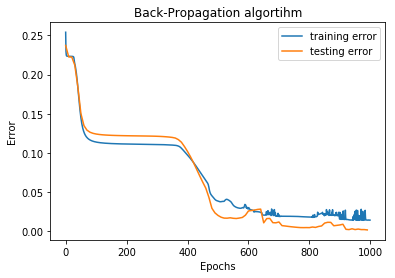

In [10]:
"""Iris dataset learning"""

#get the iris dataset
def get_dataset():
    f = open("./iris_data/iris.data")
    
    lines = f.readlines()
    f.close()
    
    np.random.shuffle(lines)
    input = []
    output = []
    training_set = {}
    testing_set = {}
    for line in lines:
        if(len(line) > 1):
            x_0, x_1, x_2, x_3, y = line.replace('\n','').split(',')
            input.append([float(x_0),float(x_1),float(x_2),float(x_3)])
            
            if y == 'Iris-setosa':
                output.append([1,0,0])
            if y == 'Iris-versicolor':
                output.append([0,1,0])
            if y == 'Iris-virginica':
                output.append([0,0,1])
            
            training_set = {
                'input': np.array(input[0:120]),
                'output': np.array(output[0:120])
            }
            
            testing_set =  {
                'input': np.array(input[121:151]),
                'output': np.array(output[121:151])
            }
            
    return (training_set, testing_set)
    

my_mlp = MLP([4, 2, 3, 3])

training_set, testing_set = get_dataset()

training_err, testing_err = my_mlp.train(1000, 0.05, training_set, testing_set, 10)


my_mlp.graph_error(training_err, testing_err)
